# Predict admissions from projected age data

Predict health levels of the new populations and then predict the stroke admissions.

## Code setup

In [1]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Linear regression fits to create health proportions from ages:

In [2]:
df_health_lines = pl.read_csv(os.path.join('outputs', 'line_fits_age_to_health.csv'))

df_health_lines.head()

imd_bin_min,imd_bin_max,col_age,col_health,m,c,rsquared
f64,f64,str,str,f64,f64,f64
2.2122,7.708,"""age_less65_proportion""","""prop_good_health""",0.3543778,0.5874175,0.6364851
2.2122,7.708,"""age_less65_proportion""","""prop_fair health""",-0.264882,0.3105843,0.6541842
2.2122,7.708,"""age_less65_proportion""","""prop_bad health""",-0.089496,0.1019982,0.4586286
2.2122,7.708,"""age_65_proportion""","""prop_good_health""",-1.484968,0.9440812,0.4800753
2.2122,7.708,"""age_65_proportion""","""prop_fair health""",1.1150576,0.0437121,0.497979


Linear regression fits to create admissions from health proportions:

In [3]:
df_admissions_lines = pl.read_csv(os.path.join('outputs', 'line_fits_health_to_admissions.csv'))

df_admissions_lines.head()

imd_bin_min,imd_bin_max,coeff_good_health,coeff_fair_health,coeff_bad_health,rsquared
f64,f64,f64,f64,f64,f64
2.2122,7.708,0.0,0.008549,0.017694,0.5722268
7.708,10.369,0.0,0.0101521,0.0091246,0.5156227
10.369,12.74375,0.0,0.0118571,0.0027425,0.5254204
12.74375,15.2564,0.0,0.0119053,0.0023227,0.565176
15.2564,18.32929,0.0,0.0121379,0.0,0.5270501


The projected data file names contain these labels:

In [4]:
proj_years_str = ['2025', '2030', '2035', '2040']

Load in the data and store in a dictionary:

In [5]:
dict_df_proj_scaled = {}

for label in proj_years_str:
    df = pl.read_csv(os.path.join('data', 'projections', f'msoa_projections_props_{label}.csv'))
    dict_df_proj_scaled[label] = df

Check one of them:

In [6]:
dict_df_proj_scaled[proj_years_str[-1]]

MSOA,MSOA11CD,country,total_patients,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,str,str,i64,f64,f64,f64,f64,f64
"""Darlington 001""","""E02002559""","""E""",8996,0.0607,0.0649,0.0607,0.718,0.0957
"""Darlington 002""","""E02002560""","""E""",6101,0.0606,0.0649,0.0606,0.7181,0.0957
"""Darlington 003""","""E02002561""","""E""",5840,0.0606,0.0649,0.0606,0.7182,0.0957
"""Darlington 004""","""E02002562""","""E""",6170,0.0608,0.065,0.0606,0.718,0.0956
"""Darlington 005""","""E02002563""","""E""",5556,0.0607,0.065,0.0607,0.718,0.0958
…,…,…,…,…,…,…,…,…
"""West Somerset 001""","""E02006113""","""E""",9210,0.0726,0.0781,0.0713,0.6606,0.1174
"""West Somerset 002""","""E02006114""","""E""",8459,0.0726,0.0781,0.0714,0.6606,0.1173
"""West Somerset 003""","""E02006115""","""E""",9074,0.0726,0.0781,0.0714,0.6606,0.1173


Load MSOA demographic data for the IMD scores:

In [7]:
path_to_msoa_stats = os.path.join('data', 'msoa_cleaned.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

# Only keep IMD column:
df_stats = df_stats[['MSOA11CD', 'IMD2019Score']]

In [8]:
df_stats.head()

MSOA11CD,IMD2019Score
str,f64
"""E02006534""",16.924833
"""E02006535""",6.4704
"""E02006536""",13.7334
"""E02006537""",26.199857
"""E02006538""",11.7948


Merge IMD scores into age projection data:

In [9]:
for label, df in dict_df_proj_scaled.items():
    df = df.join(df_stats, on='MSOA11CD')
    dict_df_proj_scaled[label] = df

Set up bins for IMD scores:

(can't recalculate from scratch as this data is missing Welsh MSOA that contributed to original IMD bin widths)

In [10]:
# dict_quantiles = {}

# for q in np.arange(0.0, 1.01, 0.1):
#     v = df_stats['IMD2019Score'].quantile(q)
#     dict_quantiles[round(q, 1)] = round(v, 5)

In [11]:
dict_quantiles = {
    0.0: 2.2122,
    0.1: 7.708,
    0.2: 10.369,
    0.3: 12.74375,
    0.4: 15.2564,
    0.5: 18.32929,
    0.6: 21.81475,
    0.7: 26.36117,
    0.8: 31.84075,
    0.9: 40.6996,
    1.0: 87.02675
}

Pick out just the values for the left edges of the bins:

In [12]:
imd_bin_left_edges = {}
for k in list(dict_quantiles.keys())[:-1]:
    imd_bin_left_edges[k] = dict_quantiles[k]

In [13]:
imd_bin_left_edges

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.3: 12.74375,
 0.4: 15.2564,
 0.5: 18.32929,
 0.6: 21.81475,
 0.7: 26.36117,
 0.8: 31.84075,
 0.9: 40.6996}

Place MSOA into these bins:

In [14]:
def bin_imds(df_stats, dict_quantiles):
    # Make columns for the results with a placeholder value:
    df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_min'))
    df_stats = df_stats.with_columns(pl.lit(0).alias('imd_bin_max'))
    
    for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
        # Pick out the bin edges:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        # Find a mask for the demographic data that contains
        # only MSOA with IMD scores in this bin.
        mask = (df_stats['IMD2019Score'] >= q0) & (df_stats['IMD2019Score'] < q1)
        if q == len(dict_quantiles) - 2:
            # Also allow values at the right edge of the final bin.
            mask = mask | (df_stats['IMD2019Score'] == q1)
    
        # Update the bin min/max values for these rows:
        df_stats = df_stats.with_columns(
            pl.when((mask))
            .then(q0)         # replace with bin min
            .otherwise(pl.col('imd_bin_min'))  # otherwise keep the existing value
            .name.keep()
        )
        df_stats = df_stats.with_columns(
            pl.when((mask))
            .then(q1)         # replace with bin min
            .otherwise(pl.col('imd_bin_max'))  # otherwise keep the existing value
            .name.keep()
        )
    return df_stats

In [15]:
for label, df in dict_df_proj_scaled.items():
    df = bin_imds(df, dict_quantiles)
    dict_df_proj_scaled[label] = df

Check that data was binned correctly:

In [16]:
dict_df_proj_scaled[proj_years_str[-1]][['IMD2019Score', 'imd_bin_min', 'imd_bin_max']]

IMD2019Score,imd_bin_min,imd_bin_max
f64,f64,f64
16.924833,15.2564,18.32929
6.4704,2.2122,7.708
13.7334,12.74375,15.2564
26.199857,21.81475,26.36117
11.7948,10.369,12.74375
…,…,…
3.25925,2.2122,7.708
7.29475,2.2122,7.708
12.117,10.369,12.74375


## Predict health

Use the projected age proportions to calculate new health proportions.

In [31]:
def predict_health_props(df_stats, dict_quantiles, df_health_lines):
    # Make a copy of the MSOA data:
    df_p_health_props = df_stats
    # Make columns for the results with a placeholder value:
    props_health = ['prop_good_health', 'prop_fair health', 'prop_bad health']
    for p in props_health:
        new_col = f'{p}_pred'
        df_p_health_props = df_p_health_props.with_columns(pl.lit(0).alias(new_col))
    
    for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
        # Pick out the bin edges:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        # Find a mask for the demographic data that contains
        # only MSOA with IMD scores in this bin.
        mask = (df_p_health_props['IMD2019Score'] >= q0) & (df_p_health_props['IMD2019Score'] < q1)
        if q == len(dict_quantiles) - 2:
            # Also allow values at the right edge of the final bin.
            mask = mask | (df_p_health_props['IMD2019Score'] == q1)
    
        # Pick out the line parameters for this IMD / age combo:
        props_age = [c for c in df_stats.columns if (('prop' in c) & ('age' in c))]
        for health_col in props_health:
            for age_band in props_age:
                # Pick out line params:
                mask_line = (
                    (df_health_lines['imd_bin_min'] == q0) &
                    (df_health_lines['col_age'] == age_band) &
                    (df_health_lines['col_health'] == health_col)
                )
                m = df_health_lines.filter(mask_line)['m'].to_numpy()[0]
                c = df_health_lines.filter(mask_line)['c'].to_numpy()[0]
    
                # mask_here = mask & ()
                # Calculate new props:
                df_p_health_props = df_p_health_props.with_columns(
                    pl.when((mask))
                    .then(m * df_p_health_props[age_band] + c)  # replace with calculated values
                    .otherwise(pl.col(f'{health_col}_pred'))  # otherwise keep the existing value
                    .name.keep()
                )
    # Convert proportions to numbers:
    df_p_health_props = df_p_health_props.with_columns((df_p_health_props['prop_good_health_pred'] * df_p_health_props['total_patients']).alias('n_good_health'))
    df_p_health_props = df_p_health_props.with_columns((df_p_health_props['prop_fair health_pred'] * df_p_health_props['total_patients']).alias('n_fair_health'))
    df_p_health_props = df_p_health_props.with_columns((df_p_health_props['prop_bad health_pred'] * df_p_health_props['total_patients']).alias('n_bad_health'))
    
    # Round to nearest integer:
    for col in ['n_good_health', 'n_fair_health', 'n_bad_health']:
        df_p_health_props = df_p_health_props.with_columns(pl.col(col).round(0).cast(int))
    return df_p_health_props

In [32]:
for label, df in dict_df_proj_scaled.items():
    df = predict_health_props(df, dict_quantiles, df_health_lines)
    dict_df_proj_scaled[label] = df

View the results:

In [33]:
dict_df_proj_scaled[proj_years_str[-1]]

MSOA,MSOA11CD,country,total_patients,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion,IMD2019Score,imd_bin_min,imd_bin_max,prop_good_health_pred,prop_fair health_pred,prop_bad health_pred,n_good_health,n_fair_health,n_bad_health
str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
"""Adur 001""","""E02006534""","""E""",9502,0.0677,0.0683,0.0622,0.7079,0.094,16.924833,15.2564,18.32929,0.778525,0.161331,0.060144,7398,1533,571
"""Adur 002""","""E02006535""","""E""",7394,0.0676,0.0683,0.0622,0.7079,0.094,6.4704,2.2122,7.708,0.836635,0.124147,0.039218,6186,918,290
"""Adur 003""","""E02006536""","""E""",7912,0.0676,0.0684,0.0622,0.7078,0.094,13.7334,12.74375,15.2564,0.794066,0.151954,0.05398,6283,1202,427
"""Adur 004""","""E02006537""","""E""",11288,0.0677,0.0683,0.0622,0.7078,0.094,26.199857,21.81475,26.36117,0.742201,0.181457,0.076343,8378,2048,862
"""Adur 005""","""E02006538""","""E""",9503,0.0677,0.0683,0.0622,0.7079,0.094,11.7948,10.369,12.74375,0.802013,0.14681,0.051177,7622,1395,486
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""York 020""","""E02002791""","""E""",7127,0.0505,0.0529,0.0494,0.7662,0.081,3.25925,2.2122,7.708,0.848089,0.115657,0.036254,6044,824,258
"""York 021""","""E02002792""","""E""",7672,0.0504,0.0529,0.0494,0.7663,0.0809,7.29475,2.2122,7.708,0.848177,0.115591,0.036231,6507,887,278
"""York 022""","""E02002793""","""E""",9991,0.0504,0.0529,0.0494,0.7663,0.0809,12.117,10.369,12.74375,0.815539,0.136776,0.047685,8148,1367,476


## Predict admissions from age proportions

Bring the two models together.

Use the health proportions that have just been calculated and use the admissions prediction function from before.

First convert proportions of each health type into numbers with each health type:

In [34]:
def calculate_admissions_from_health(df_stats, df_admissions_lines, col_n_good, col_n_fair, col_n_bad):
    # Make a copy of the MSOA data:
    cols_to_keep = ['MSOA', 'IMD2019Score', ] + [col_n_good, col_n_fair, col_n_bad]
    df_p_admissions = df_stats[cols_to_keep]
    # Make column for the results with a placeholder value:
    col_admissions_pred = 'admissions_predicted'
    df_p_admissions = df_p_admissions.with_columns(pl.lit(0).alias(col_admissions_pred))
    
    for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
        # Pick out the bin edges:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        # Find a mask for the demographic data that contains
        # only MSOA with IMD scores in this bin.
        mask = (df_p_admissions['IMD2019Score'] >= q0) & (df_p_admissions['IMD2019Score'] < q1)
        if q == len(dict_quantiles) - 2:
            # Also allow values at the right edge of the final bin.
            mask = mask | (df_p_admissions['IMD2019Score'] == q1)
    
        # Pick out the line parameters for this IMD:
        mask_coeffs = ((df_admissions_lines['imd_bin_min'] == q0))
        coeff_good = df_admissions_lines.filter(mask_coeffs)['coeff_good_health'].to_numpy()[0]
        coeff_fair = df_admissions_lines.filter(mask_coeffs)['coeff_fair_health'].to_numpy()[0]
        coeff_bad = df_admissions_lines.filter(mask_coeffs)['coeff_bad_health'].to_numpy()[0]

        # Calculate new props:
        df_p_admissions = df_p_admissions.with_columns(
            pl.when((mask))
            .then(
                sum([
                    coeff_good * df_p_admissions[col_n_good],
                    coeff_fair * df_p_admissions[col_n_fair],
                    coeff_bad * df_p_admissions[col_n_bad]
                ]))  # replace with calculated values
            .otherwise(pl.col(col_admissions_pred))  # otherwise keep the existing value
            .name.keep()
        )
    return df_p_admissions[['MSOA', col_admissions_pred]]

In [35]:
for label, df in dict_df_proj_scaled.items():
    df = calculate_admissions_from_health(df, df_admissions_lines, 'n_good_health', 'n_fair_health', 'n_bad_health')
    dict_df_proj_scaled[label] = df

Check results:

In [36]:
dict_df_proj_scaled[proj_years_str[-1]]

MSOA,admissions_predicted
str,f64
"""Adur 001""",18.607401
"""Adur 002""",12.979242
"""Adur 003""",15.301964
"""Adur 004""",23.133262
"""Adur 005""",17.87351
…,…
"""York 020""",11.609428
"""York 021""",12.501895
"""York 022""",17.514086


2025 13.1651698


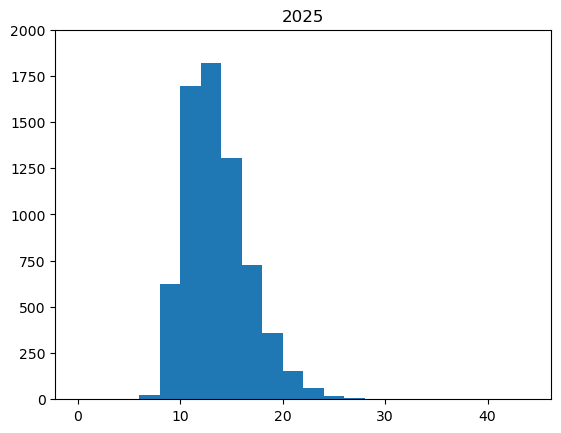

2030 14.235900699999998


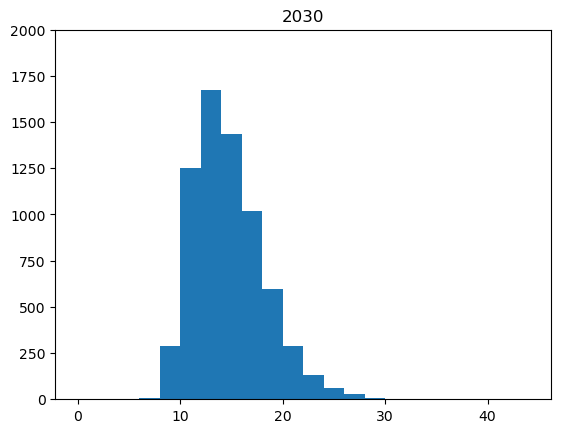

2035 14.8246314


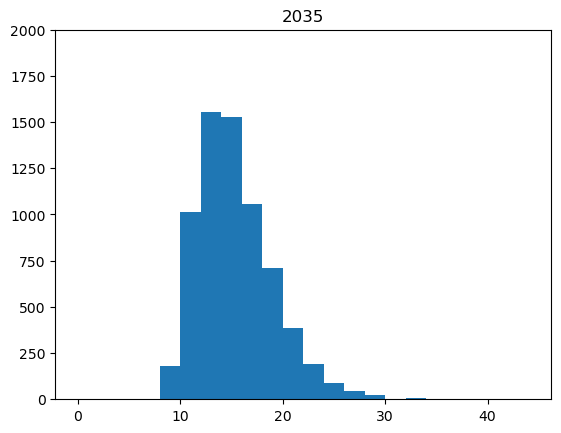

2040 15.53246285


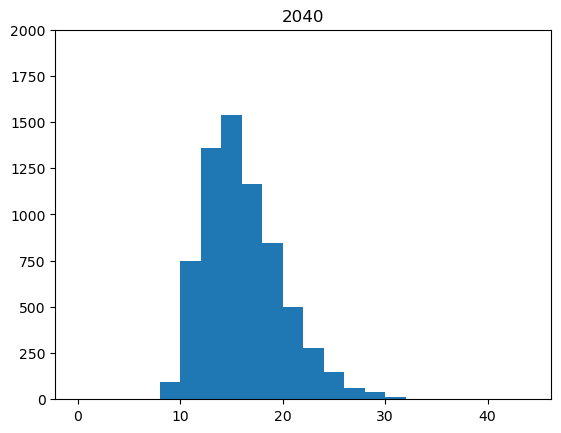

In [42]:
for label, df in dict_df_proj_scaled.items():
    print(label, df['admissions_predicted'].median())
    fig, ax = plt.subplots()
    ax.hist(df['admissions_predicted'], bins=range(0, 45, 2))
    ax.set_title(label)
    ax.set_ylim(0, 2000)
    plt.show()